In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from time import time

In [2]:
def create_subgraphs(reverse = False):
    """
    Creates subgraphs of the Higgs dataset with the full timestamps
    :return: nothing
    """
    activity_time_path = "../network-data/higgs-activity_time.txt"
    if reverse:
        activity_time = pd.read_csv(activity_time_path, delimiter = ' ', names=['target', 'source', 'time', 'type'])
    else: 
        activity_time = pd.read_csv(activity_time_path, delimiter = ' ', names=['source', 'target', 'time', 'type'])


    # create high resolution timestamped datasets
    reply_timestamps_file_path = "../output/reply_timestamps.edgelist"
    mention_timestamps_file_path = "../output/mention_timestamps.edgelist"
    retweet_timestamps_file_path = "../output/retweet_timestamps.edgelist"

    activity_time[activity_time['type'] == 'RE'][['source', 'target', 'time']].to_csv(reply_timestamps_file_path, sep=' ', header=False, index=False)
    activity_time[activity_time['type'] == 'MT'][['source', 'target', 'time']].to_csv(mention_timestamps_file_path, sep=' ', header=False, index=False)
    activity_time[activity_time['type'] == 'RT'][['source', 'target', 'time']].to_csv(retweet_timestamps_file_path, sep=' ', header=False, index=False)

def largest_connected_component(G):
    """
    Returns the largest connected component of a graph
    :param G: graph
    :return: largest connected component
    """
    # not supported for directed networks
    if isinstance(G, nx.DiGraph):
        return G.subgraph(max(nx.weakly_connected_components(G), key=len))
    else:
        return G.subgraph(max(nx.connected_components(G), key=len))

def build_df_from_graph(graph, bin_size=1000):
    graph_df = pd.DataFrame(graph.edges(data=True), columns=['source', 'target', 'attribute'])
    # Extract the 'timestamp' attribute from the 'attribute' column and add it as a separate column
    graph_df['timestamp'] = [d['time'] for d in graph_df['attribute']]
    min_t = min(graph_df['timestamp'])

    # Hardcoded normalizing to ~1000 timesteps
    graph_df['timestamp'] = ((graph_df['timestamp'] - min_t) / bin_size).astype(int)
    # subgraph_df['timestamp'] = ((subgraph_df['timestamp'] - min_t)).astype(int)
    # Drop the 'attribute' column, which is no longer needed
    graph_df.drop('attribute', axis=1, inplace=True)

    graph_df = graph_df.sort_values(by=['timestamp'])
    graph_df.reset_index(drop=True, inplace=True)

    return graph_df

def build_social_network_df(graph):
    social_network_df = pd.DataFrame(graph.edges(data=True), columns=['source', 'target', 'attribute'])
        # Drop the 'attribute' column, which is no longer needed
    social_network_df.drop('attribute', axis=1, inplace=True)
    social_network_df = social_network_df.drop_duplicates()
    return social_network_df

def get_start_end_combined(subgraph_reply_df, subgraph_mention_df, subgraph_retweet_df):
    start_timestamp_reply = min(subgraph_reply_df['timestamp'])
    start_timestamp_mention = min(subgraph_mention_df['timestamp'])
    start_timestamp_retweet = min(subgraph_retweet_df['timestamp'])
    end_timestamp_reply = max(subgraph_reply_df['timestamp'])
    end_timestamp_mention = max(subgraph_mention_df['timestamp'])
    end_timestamp_retweet = max(subgraph_retweet_df['timestamp'])

    start_timestamp = min(start_timestamp_reply, start_timestamp_mention, start_timestamp_retweet)
    end_timestamp = max(end_timestamp_reply, end_timestamp_mention, end_timestamp_retweet)
    return start_timestamp, end_timestamp

In [3]:
create_subgraphs()

In [4]:
df_social = pd.read_csv("../network-data/higgs-social_network.edgelist", delimiter = ' ', names=['source', 'target'])
df_reply = pd.read_csv("../output/reply_timestamps.edgelist", delimiter=" ", names=['source', 'target', 'timestamp'])
df_mention = pd.read_csv("../output/mention_timestamps.edgelist", delimiter=" ", names=['source', 'target', 'timestamp'])
df_retweet = pd.read_csv("../output/retweet_timestamps.edgelist", delimiter=" ", names=['source', 'target', 'timestamp'])

In [6]:

# Node 88 is retweeted a very large amount ...
(df_retweet['target'] == 88).sum()

18977

In [7]:
following = df_social.value_counts('source').rename('following')
replies = df_reply.value_counts('source').rename('replies')
mentions = df_mention.value_counts('source').rename('mentions')
retweets = df_retweet.value_counts('source').rename('retweets')

followers = df_social.value_counts('target').rename('followers')
is_replied_to = df_reply.value_counts('target').rename('is_replied_to')
is_mentioned = df_mention.value_counts('target').rename('is_mentioned')
is_retweeted = df_retweet.value_counts('target').rename('is_retweeted')

In [8]:
def create_plot_grid(fig, h, w):
    return [fig.add_subplot(h, w, w*row + col) for row in range(0, h) for col in range(1, w+1)]

Text(0.5, 0.98, 'followers and following distribution')

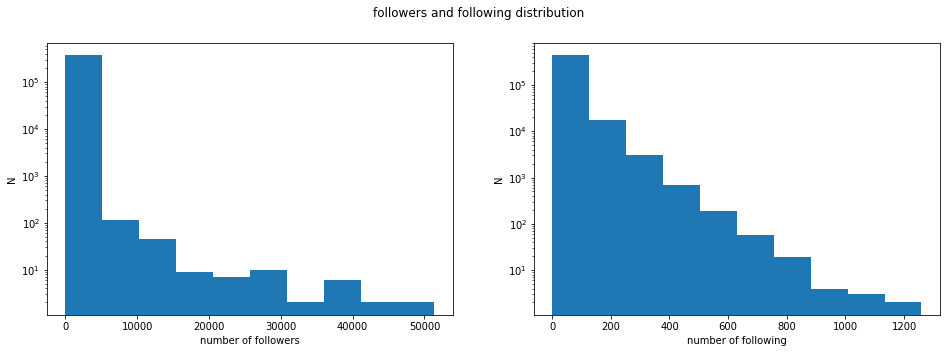

In [9]:
fig = plt.figure(figsize=(16,5))

ax1, ax2 = create_plot_grid(fig, 1, 2)

ax1.hist(followers.values)
ax1.set_yscale('log')
ax1.set_ylabel('N')
ax1.set_xlabel('number of followers')

ax2.set_yscale('log')

ax2.hist(following.values)
ax2.set_ylabel('N')
ax2.set_xlabel('number of following')
fig.suptitle('followers and following distribution')

In [11]:
users = pd.concat([followers, following, is_replied_to, replies, is_mentioned, mentions, is_retweeted, retweets], axis = 1)
users = users.fillna(0)

In [12]:
# set all nan value to 0 
users[users.isna()] = 0

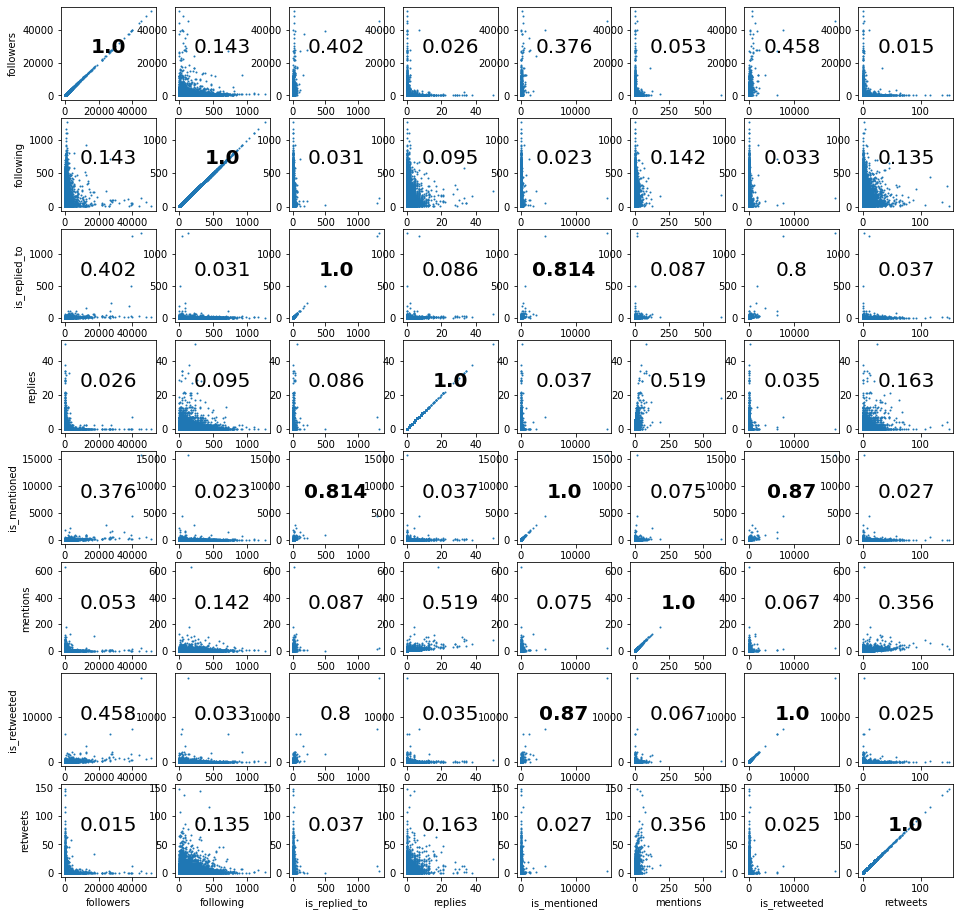

In [13]:

columns = users.columns[:]
x_columns = columns[:-1]
y_columns = columns[1:]
n_columns = len(columns)
fig = plt.figure(figsize=(16,16))
axes = create_plot_grid(fig, n_columns, n_columns)
axes = np.array(axes).reshape(n_columns, n_columns)

corr_data = {}

centers = (users.max() + users.min()) / 2.0

heatmap_data = np.zeros((n_columns, n_columns))

for i, col_y in enumerate(columns):
    corr_data[col_y] = {}
        
    for j, col_x in enumerate(columns):
        x, y = (users[col_x], users[col_y])
      
        center_x, center_y = (centers[col_x], centers[col_y])
        ax = axes[i,j]
        ax.scatter(x,y, s = 1)
        if j == 0:
            ax.set_ylabel(col_y)
        if i == n_columns - 1:
            ax.set_xlabel(col_x)
        corr = np.corrcoef(x, y)[0][1]
        # print(corr)
        corr_data[col_y][col_x] = corr
        heatmap_data[i, j] = corr
        if corr > 0.8:
            ax.text(center_x, center_y, round(corr, 3), fontweight="bold", fontsize = 20, horizontalalignment='center')
        else:
            ax.text(center_x, center_y, round(corr, 3), fontsize = 20, horizontalalignment='center')


        


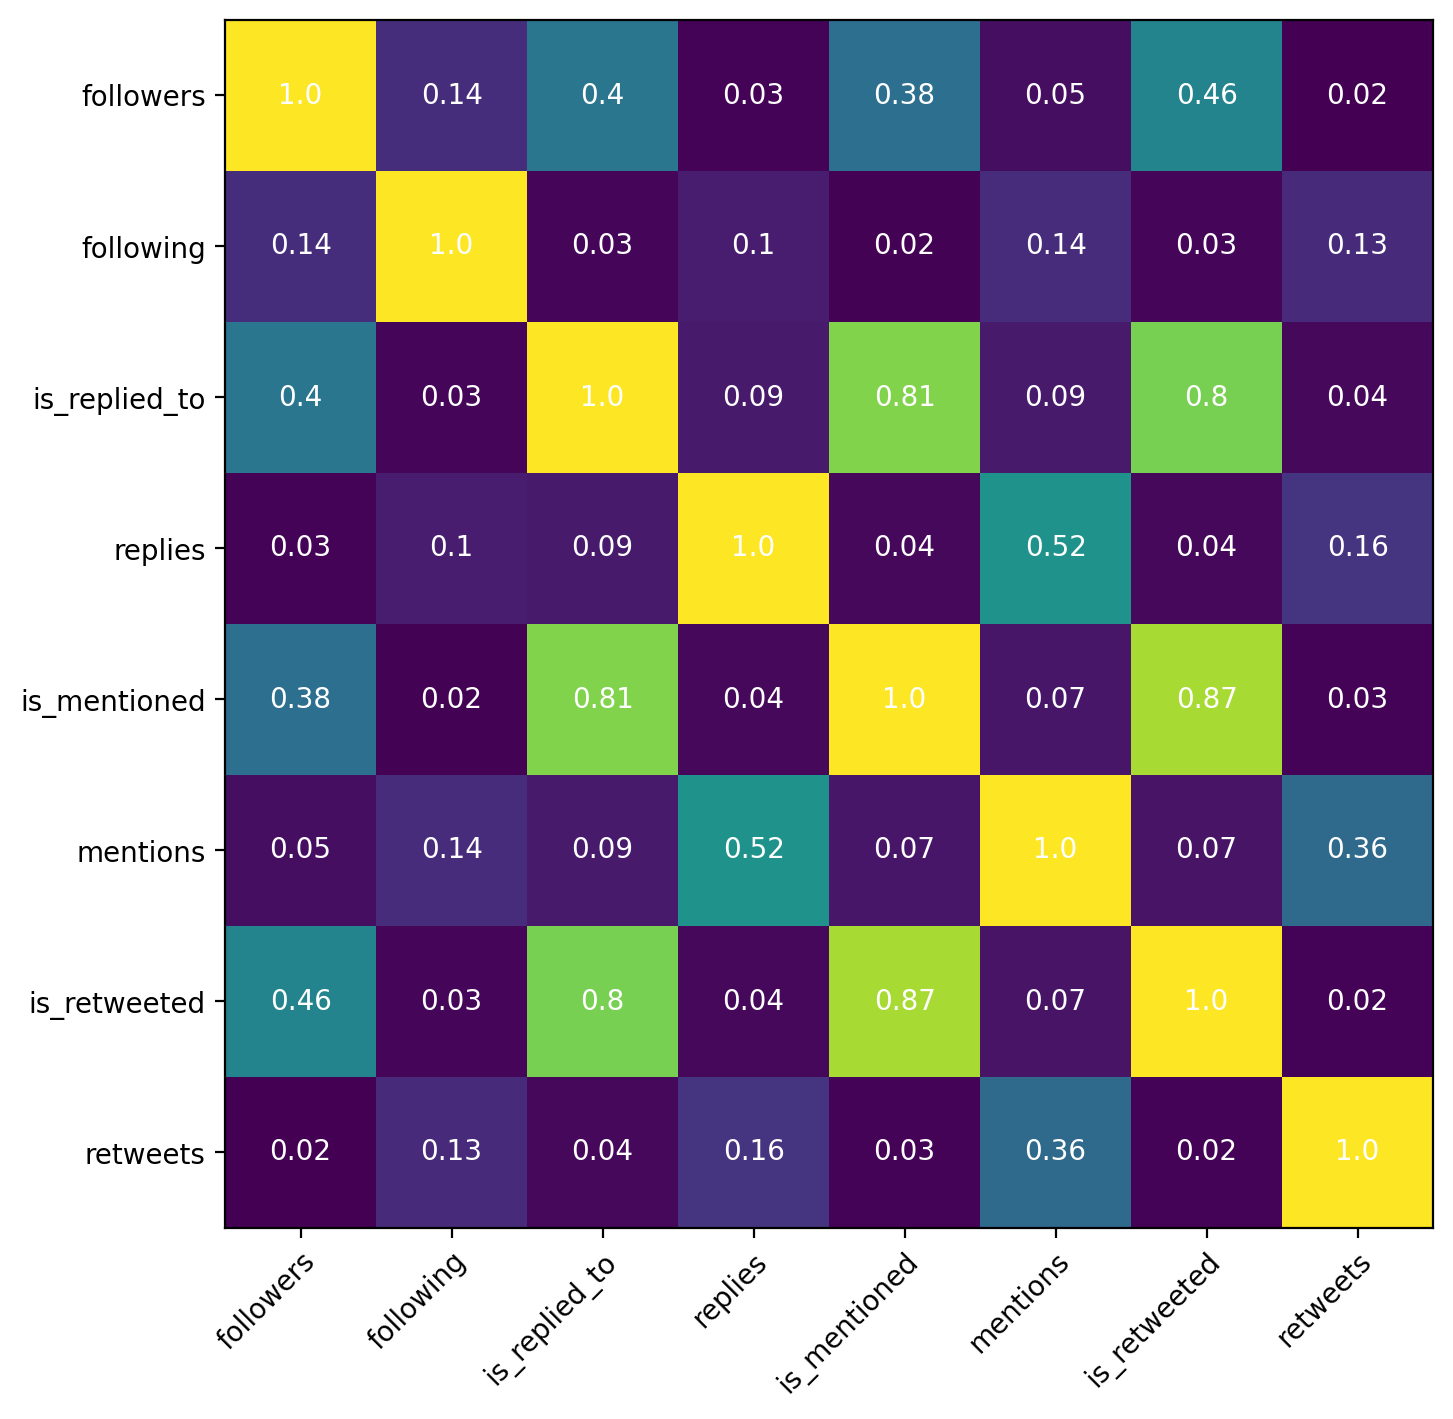

In [14]:
fig = plt.figure(figsize=(8,8), dpi = 200)
ax = fig.add_subplot(111)
ax.imshow(heatmap_data)
# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(columns)))
ax.set_xticklabels(columns)
ax.set_yticks(np.arange(len(columns)))
ax.set_yticklabels(columns)
# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(columns)):
    for j in range(len(columns)):
        text = ax.text(j, i, round(heatmap_data[i, j],2),
                       ha="center", va="center", color="w")